Comparing the algorithms

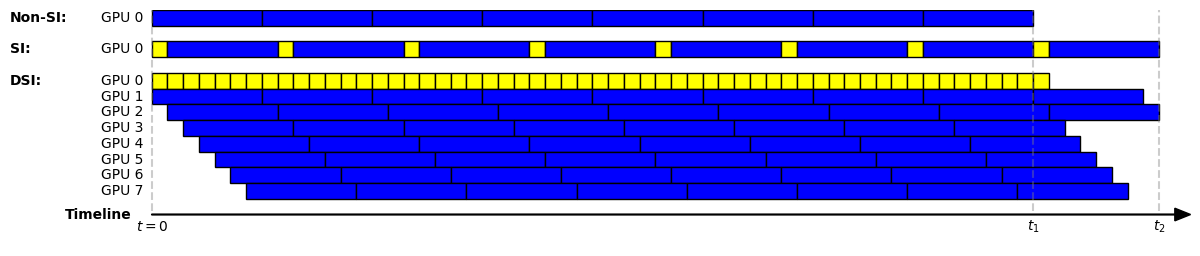

In [145]:
from dataclasses import dataclass
from typing import List

import matplotlib.pyplot as plt


@dataclass
class TimeUnit:
    width: int
    color: None | str


@dataclass
class GPU:
    time_units: List[TimeUnit]


@dataclass
class Algorithm:
    name: str
    gpus: List[GPU]


def draw_time_unit(ax, time_unit: TimeUnit, x, y):
    """Draw a rectangle at position (x, y) based on the TimeUnit dataclass.
    If the color is None, the rectangle transparent with no border so that it fills the
    space but doesn't show."""
    if time_unit.color is None:
        ax.add_patch(
            plt.Rectangle(
                (x, y), time_unit.width, 1, edgecolor="none", facecolor="none"
            )
        )
    else:
        ax.add_patch(
            plt.Rectangle(
                (x, y), time_unit.width, 1, edgecolor="black", facecolor=time_unit.color
            )
        )


def draw_gpu(ax, gpu: GPU, y_offset, algorithm_name=None, gpu_label=None):
    """Draw a row of rectangles based on the GPU dataclass."""
    x_start = 0
    for time_unit in gpu.time_units:
        draw_time_unit(ax, time_unit, x_start, y_offset)
        x_start += time_unit.width
    if algorithm_name:
        ax.text(
            -9,
            y_offset + 0.5,
            algorithm_name,
            ha="left",
            va="center",
            fontsize=10,
            fontweight="bold",
        )
    if gpu_label:
        ax.text(-0.5, y_offset + 0.5, gpu_label, ha="right", va="center", fontsize=10)


def draw_algorithm(ax, algorithm: Algorithm, start_y):
    """Draw all GPUs of an algorithm with consistent spacing."""
    for i, gpu in enumerate(algorithm.gpus):
        algorithm_name = f"{algorithm.name}:" if i == 0 else ""
        gpu_label = f"GPU {i}"
        draw_gpu(ax, gpu, start_y - i, algorithm_name, gpu_label)
    return start_y - len(algorithm.gpus)


def setup_axes(ax):
    """Configure the plot axes for better visualization."""
    ax.set_xlim(-5, 66)
    ax.set_ylim(-14, 1)  # Adjust based on the number of rows and spacing required
    ax.set_aspect("equal")
    ax.axis("off")
    # Draw an arrow indicating the timeline
    ax.arrow(0, -12, 65, 0, head_width=0.8, head_length=1, fc="k", ec="k", width=0.05)
    # Left to arrow
    ax.text(
        -5.5,
        -12,
        "Timeline",
        ha="left",
        va="center",
        fontsize=10,
        fontweight="bold",
    )


def plot_timepoint(ax, x, label):
    """Draw a vertical dashed line at x and label it."""
    ax.axvline(x, color="gray", linestyle="--", alpha=0.4, ymin=0.15)
    ax.text(x, -12.8, label, ha="center", va="center", fontsize=10)


def plot_graph():
    target_latency = 7
    # Define the Alternatives and Rows (unchanged)
    alg_a = Algorithm(
        name="Non-SI",
        gpus=[GPU(time_units=[TimeUnit(width=target_latency, color="blue")] * 8)],
    )

    alg_b = Algorithm(
        name="SI",
        gpus=[
            GPU(
                time_units=[
                    *(
                        [TimeUnit(width=1, color="yellow")]
                        + [TimeUnit(width=target_latency, color="blue")]
                    )
                ]
                * 8
            )
        ],
    )

    alg_c = Algorithm(
        name="DSI",
        gpus=[
            GPU(time_units=[TimeUnit(width=1, color="yellow")] * 57),
            GPU(time_units=[TimeUnit(width=target_latency, color="blue")] * 9),
            GPU(
                time_units=[TimeUnit(width=1, color=None)]
                + [TimeUnit(width=target_latency, color="blue")] * 9
            ),
            GPU(
                time_units=[TimeUnit(width=1, color=None)] * 2
                + [TimeUnit(width=target_latency, color="blue")] * 8
            ),
            GPU(
                time_units=[TimeUnit(width=1, color=None)] * 3
                + [TimeUnit(width=target_latency, color="blue")] * 8
            ),
            GPU(
                time_units=[TimeUnit(width=1, color=None)] * 4
                + [TimeUnit(width=target_latency, color="blue")] * 8
            ),
            GPU(
                time_units=[TimeUnit(width=1, color=None)] * 5
                + [TimeUnit(width=target_latency, color="blue")] * 8
            ),
            GPU(
                time_units=[TimeUnit(width=1, color=None)] * 6
                + [TimeUnit(width=target_latency, color="blue")] * 8
            ),
        ],
    )

    # Create figure and plot
    fig, ax = plt.subplots(figsize=(12, 10))
    setup_axes(ax)

    # Plotting each alternative using draw_algorithm
    start_y = 0
    start_y = draw_algorithm(ax, alg_a, start_y)
    start_y = draw_algorithm(ax, alg_b, start_y - 1)
    draw_algorithm(ax, alg_c, start_y - 1)

    # Plot timepoints
    non_si_end_x = 8 * target_latency  # Calculate the x position
    si_end_x = non_si_end_x + 1 + target_latency
    plot_timepoint(ax, 0, "$t=0$")
    plot_timepoint(ax, non_si_end_x, "$t_1$")
    plot_timepoint(ax, si_end_x, "$t_2$")

    plt.tight_layout()
    plt.show()


plot_graph()